Hello, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> "Improve" comments mean that there are tiny corrections that could help you to make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* You've worked really hard and submitted a solid project.
* Your code style looks good. It was a pleasure to review your project.
* I've found some tiny mistakes in your project. Hope, they'll be easy to fix.
* There are few things I'd like you to check. It's not a mistakes, but your project could be improved by following these comments.
* Every issue with our code is a chance for us to learn something new. Good luck!

## Mining for Gold / Data
This report analyzes mining data, specifically the recovery of gold. The goal of this project was to analyze the raw data and find the best statistical model to predict the output of gold. Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.

Our goal is to build a statistical model that can predict the coefficients, and help us to find the share of gold in the concentrate and the tails. In the first few steps, I clean and analyze the data before adding new calculations and testing a few different regression models. 

## 1.1 Open the files and look into the data.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

In [3]:
from matplotlib import pyplot

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that all imports are collected in the first cell!
</div>

In [4]:
# we've been told that full dataset consists of train and test data
# data was previously split as seen here
# making date the index, to make it easier to work with data
train = pd.read_csv('/Users/mitzibandera/Data Files/Mining Gold/gold_recovery_train.csv', index_col = 'date')
test = pd.read_csv('/Users/mitzibandera/Data Files/Mining Gold/gold_recovery_test.csv', index_col = 'date')
full = pd.read_csv('/Users/mitzibandera/Data Files/Mining Gold/gold_recovery_full.csv', index_col = 'date')

In [5]:
def inspect_df(df):
    display(df.info())
    display(df.describe())
    display(df.head(3))
    print("\033[1m" + 'We have {} duplicated rows.'.format(df.duplicated().sum()) + "\033[0m")
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],4) *100
    print(df_nulls.head(10).sort_values(by = 'Missing Values', ascending = False))

In [6]:
inspect_df(train)

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


We have 16 duplicated rows.
                               Missing Values  Percent of Nulls
final.output.recovery                    1521              9.02
primary_cleaner.input.sulfate            1307              7.75
final.output.concentrate_sol              370              2.19
final.output.tail_pb                      183              1.09
final.output.tail_sol                     145              0.86
final.output.concentrate_ag                72              0.43
final.output.concentrate_pb                72              0.43
final.output.concentrate_au                71              0.42
final.output.tail_ag                       66              0.39
final.output.tail_au                       66              0.39


In [7]:
inspect_df(test)

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


We have 6 duplicated rows.
                                          Missing Values  Percent of Nulls
primary_cleaner.input.sulfate                        302              5.16
primary_cleaner.input.depressant                     284              4.85
primary_cleaner.input.xanthate                       166              2.83
primary_cleaner.state.floatbank8_a_air                16              0.27
primary_cleaner.state.floatbank8_a_level              16              0.27
primary_cleaner.state.floatbank8_b_air                16              0.27
primary_cleaner.state.floatbank8_b_level              16              0.27
primary_cleaner.state.floatbank8_c_air                16              0.27
primary_cleaner.state.floatbank8_c_level              16              0.27
primary_cleaner.input.feed_size                        0              0.00


### Conclusion
We see that the training data was missing and null values. We'll need to impute the missing values and find a way to fill these missing values. In step 1.4, we can use the 'ffill' method since this is time series data and it would make sense to use the last observed non-null value and push it forward into cells with misising data. We can use this method and in doing so, not create false data. 

In [8]:
inspect_df(full)

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_cleaner.i

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


We have 22 duplicated rows.
                               Missing Values  Percent of Nulls
final.output.recovery                    1963              8.64
primary_cleaner.input.sulfate            1609              7.08
final.output.concentrate_sol              385              1.69
final.output.tail_sol                     271              1.19
final.output.tail_pb                      200              0.88
final.output.concentrate_ag                89              0.39
final.output.concentrate_pb                87              0.38
final.output.concentrate_au                86              0.38
final.output.tail_ag                       83              0.37
final.output.tail_au                       81              0.36


<div class="alert alert-block alert-success">
<b>Success:</b> Data loading and first look were done well. Good job!
</div>

## 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [9]:
def recovery_calculation(df): 
    C = df['rougher.output.concentrate_au']
    F = df['rougher.input.feed_au']
    T = df['rougher.output.tail_au']
    df['final_recovery_calculation'] = ((C * (F - T))/(F * (C - T))) * 100 
    return train[['final.output.recovery', 'final_recovery_calculation']]

In [10]:
recovery_calculation(train).head(3)

,final.output.recovery,final_recovery_calculation
date,,
2016-01-15 00:00:00,70.541216,87.107763
2016-01-15 01:00:00,69.266198,86.843261
2016-01-15 02:00:00,68.116445,86.842308


<div class="alert alert-info">
     Is the right thing to do to build two separate models? One for predicting roughter.output.recovery and another for predicting final.output.recovery? I wasn't sure but this is what I planned to do in the next few steps.  
</div>

<div class="alert alert-block alert-success">
<b>Success:</b> Both solutions (2 separate models or one model with 2 outputs[with the help of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html">MultiOutputRegressor</a>]) are OK.
</div>

Predicting 'final.output.recovery'

# Getting train_target
train_target = train['final.output.recovery']

# Getting train_features
train_features = train.loc[:, list(test.columns)]

<div class="alert alert-info">
     In the step above, we're also dropping features that have to do with the rougher output stage. Why do we need to do this? Wouldn't this information also help us in predicting 'final.output.recovery'? 
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> We can't calculate them before the technological process starts, so we can't use them for predictions. That's why we should drop them.
</div>

# Getting test_target - how can i get this data? 
# test_target = 

# Getting test_features
test_features = test

<div class="alert alert-info">
     Do i need to also delete outliers from test_features and test_target?
</div>

<div class="alert alert-info">
     I'm not sure if I'm on the right track..but after this, I was planning to prepare data to predict 'rougher.output.recovery'. I think I would need to discard any columns/features in the test and training sets that have to do with the stages that come after the rougher output recovery stage. After that, I would build a new model and evaluate using cross-validation. <p> Other question: 
    * Would there be a scenario where it would make sense to start from scratch and use the full dataset and then use train_test_split to help with creating the features and targets? 
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> You could use all columns that are present in test set for both targets prediction.
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> If there is already test set you can't split full data in 2 parts. Project manager would compare the result score of several programmers by this test set.
</div>

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

# Train Linear Regression Model for predicting 'final.output.recovery'
model = LinearRegression()
scores = cross_val_score(model, train_features, train_target, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> You should drop date column after all needed columns for testing are extracted from full dataset.  Also don't forget to do preprocessing in the first step[fill NaNs (the best way is to use "ffill" method in this case)].
</div>

In [11]:
def mae_calculation(df): 
    # delete missing values for calculation
    mae_df = df.dropna(how='any', subset=['final.output.recovery', 'final_recovery_calculation'])
    MAE = np.sum(np.abs(mae_df['final_recovery_calculation'] - mae_df['rougher.output.recovery']))/len(mae_df['rougher.output.recovery'])
    return MAE

### Conclusion

We see that the MAE is very small, virtually 0. This is good news and it means that the recovery was indeed calculated correctly in the dataset that was given to us. Our manual check confirmed this. 

<div class="alert alert-block alert-success">
<b>Success:</b> Absolutely right!
</div>

In [12]:
mae_calculation(train)

9.321393274977089e-15

<div class="alert alert-block alert-danger">

<b>Needs fixing:</b> What about this steps:
* 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
* 1.4. Perform data preprocessing.
    
</div>

### 1.3 Analyze the features not available in the test set. What are these parameters? What is their type?

In [13]:
# Inspecting dimensionality
train_cols = train.columns
test_cols = test.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

In [15]:
train_not_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'final_recovery_calculation', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.co

## 1.4. Perform data preprocessing.

### Conclusion
In the previous steps, I analyze the features that are not available in the test set. These include some of the output stages and generally, we should make sure the dimensionality matches. The statistical models we will build cannot have different dimesions in the training and test set. I will ensure the data matches after I analyze the substance levels. I'd like to analyze the data a bit more before dropping any information. 

I also inpute missing values in order to get the dataset ready for modeling. 

In [16]:
# filling missing data and NaN cells so we can prepare data for model training
train = train.fillna(method='ffill', axis = 0)
test = test.fillna(method='ffill', axis = 0)
full = full.fillna(method='ffill', axis = 0)

In the previous steps, I analyze the features that are not available in the test set. These include some of the output stages and generally, we should make sure the dimensionality matches. The statistical models we will build cannot have different dimesions in the training and test set. I will ensure the data matches after I analyze the substance levels. I'd like to analyze the data a bit more before dropping any information. 

## 2.1 Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage. 
## 2.3 Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

The rougher concentrate undergoes two stages of purification: 
* primary_cleaner — primary purification
* secondary_cleaner — secondary purification

The corresponding data is labeled and present in the train data: 
* 'primary_cleaner.output.concentrate_ag',
* 'final.output.concentrate_ag'
* 'primary_cleaner.output.concentrate_pb',
* 'final.output.concentrate_pb'
* 'primary_cleaner.output.concentrate_au',
* 'final.output.concentrate_au'

We'll also include the two prior stages in our analysis: 
* rougher input (for example: 'rougher.input.feed_au') 
* rougher output (for example:'rougher.output.concentrate_au') 

In the following histograms, we'll examine the substances at the stages: raw feed input, raw feed output, rougher concentrate, and final concentrate.

Gold - Au

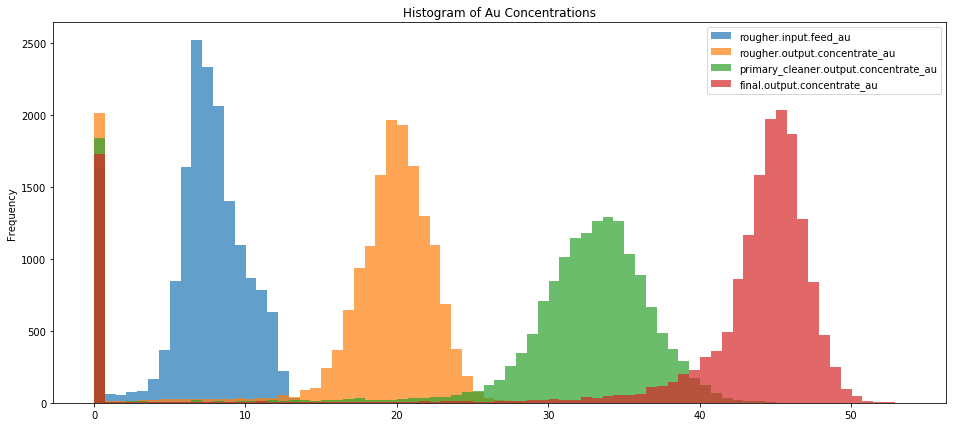

In [17]:
train.plot(kind='hist',y=['rougher.input.feed_au', 'rougher.output.concentrate_au','primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], 
           alpha = .7, bins = 75, figsize = (16,7))
plt.title('Histogram of Au Concentrations')
plt.show()

Silver - Ag

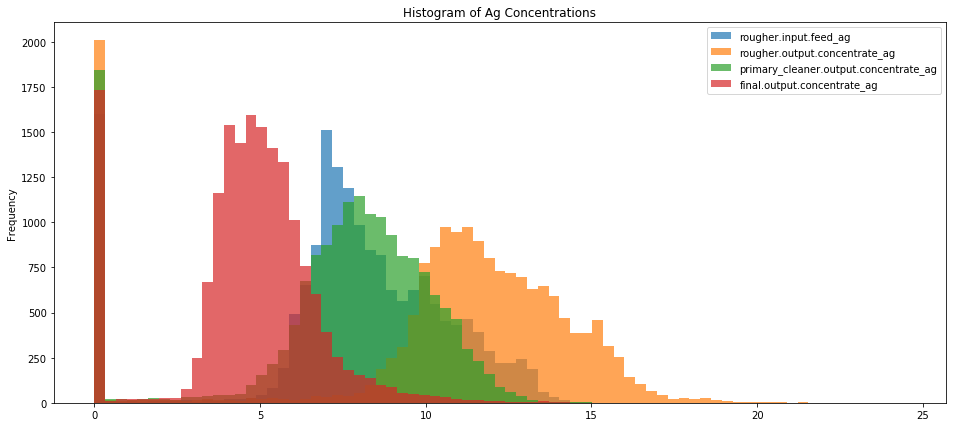

In [18]:
train.plot(kind='hist',y=['rougher.input.feed_ag', 'rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], 
           alpha = .7, bins = 75, figsize = (16,7))
plt.title('Histogram of Ag Concentrations')
plt.show()

Lead - Pb

<div class="alert alert-block alert-success">
<b>Success:</b> Great histograms.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please don't forget to provide some findings.
</div>

### Conclusion 
The histograms above show that the substances all increase in concentration as they move through the processing. One thing to note, is that there are outliers for nearly every stage and substance, we can spot these at the 0.0 mark. This immediately raises red flags, as the concentrations wouldn't make sense to be at 0. This is an outlier we will want to delete in a later step. Also, this is an observation that we might want to discuss with engineers and people at the company who are more knowledgeable about the mining process. 

## 2.2 Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

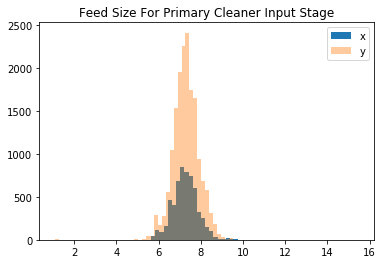

In [20]:
x = test['primary_cleaner.input.feed_size']
y = train['primary_cleaner.input.feed_size']

pyplot.hist(x, bins = 50, alpha=1, label='x')
pyplot.hist(y, bins = 50, alpha=0.4, label='y')
plt.title('Feed Size For Primary Cleaner Input Stage')
pyplot.legend(loc='upper right')
pyplot.show()

### Conclusion 
Visually, the distributions appear to be similar in the train dataset and the test dataset. This is good news! This means there are not any visible outliers and that the data appears to reflect the same patterns in both slices of data. We can continue with the test and training sets as they are when it comes to the feed size variables

### Conclusion about Feed Size
Visually, the distributions appear to be similar in the train dataset and the test dataset. This is good news! This means there are not any visible outliers and that the data appears to reflect the same patterns in both slices of data. We can continue with the test and training sets as they are when it comes to the feed size variables.

import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()Conclusion about Concentrations: Should try to delete the observations that are near or at the 0. Wouldn't make sense for there to be no rougher feed and makes even less sense that in later stages, the product would also be at 0. 
<p>Conclusion about Feed Size: Visually, the distributions appear to be similar. We can see that the train data has more observations where the rougher input feed size is smaller, around 30 and 40. We can continue with the test and training sets as they are when it comes to the feed size variables. 

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please don't forget to change names of histograms.
</div>

### Train Data - Cleaning

Here we are dropping the observations at '0' that we saw in the histograms above by removing all records where the combined concentration in the rougher output is less than 1. 

## Additional Data Processing
Now that we've had a chance to analyze the data, let's go ahead and eiliminate the anomalies like outliers and make sure the datasets are ready for modeling. 

In [23]:
# Let's identify the fields that have outliers in the data
# features_input_concentrate = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'\
#                               , 'rougher.input.feed_sol']
features_rougher_concentrate = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag'\
                                 , 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
# features_output_concentrate = ['final.output.concentrate_au', 'final.output.concentrate_ag'\
#                                 , 'final.output.concentrate_pb', 'final.output.concentrate_sol']

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> We can't compare the distributions if train and test sets with the help of histograms above. Plase make graphs with 2 histograms each(train and test distribution of same feature).
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Firstly you should visualize the histograms of total concentrations. Probably you would create new columns (e.g. sum_rougher_input).
</div>

In [26]:
# keep only features that are in test set
train_features = train.loc[:, list(test.columns)]
train_features.shape

(14858, 52)

In [27]:
# create train_target
train_targets = train[['rougher.output.recovery', 'final.output.recovery']]

In [28]:
train_targets.shape

(14858, 2)

<div class="alert alert-info">
     What is a more efficient way of dropping the observations above? 
</div>

### Conclusion 
Looking at the describe() function and running the histograms again, we see that the mean value has risen just a bit since we dropped observations close to 0. In total, 2647 observations were dropped.

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please drop outliers in test set too. You could add missing columns from full dataset. You could match dataframes by "date" column.
</div>

<div class="alert alert-info">
     When i look at train.describe() I see so many other variables where there are 0 values too. wouldn't these also affect the learning model? If yes, should we drop them now too? 
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> No, it's OK. It is a part of technological process.
</div>

### Test Data - Cleaning

Before we delete outliers from the test set, let's remember that the test set is currently incomplete. We'll need to add the missing features before we delete the outliers. Or is it will add more work to our plate. 

In [29]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final_recovery_calculation
count,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,...,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,14858.000000,1.485800e+04
mean,5.168541,10.001924,8.991834,43.298159,66.288896,9.585187,2.566389,10.180321,2.933276,131.735626,...,-479.510846,15.454968,-461.660251,16.668215,-484.412603,13.028261,-484.331153,19.497071,-507.228831,NaN
std,1.571026,1.955805,3.088749,6.833151,11.479349,2.519546,1.025184,3.328967,1.002020,42.426606,...,53.026493,5.265373,59.905591,5.874102,39.299172,5.751202,40.837575,5.783938,39.712283,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001982,...,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.470391,-800.085449,0.172697,-810.473526,-inf
25%,4.204358,9.237618,7.308736,43.005679,62.377785,7.985535,1.866023,8.505923,2.361264,105.154535,...,-500.655222,11.888752,-500.157214,11.060112,-500.375215,8.996070,-500.109126,14.988381,-500.778864,8.020387e+01
50%,5.015409,10.259445,8.780377,44.755810,67.403725,9.540705,2.563972,10.350329,2.860928,132.553262,...,-499.689759,14.968013,-499.437464,17.292325,-499.692913,11.996452,-499.913217,19.981598,-500.062490,8.544664e+01
75%,5.918020,11.162614,10.484869,46.099448,72.406626,11.101655,3.242244,11.820533,3.464621,159.942069,...,-481.256819,20.053826,-400.080088,21.008980,-488.660748,17.965687,-464.422168,24.990572,-499.522000,9.024881e+01
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,-127.692333,24.007913,-71.472472,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459,inf


In [28]:
sub_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 6 columns):
rougher.output.recovery           22716 non-null float64
final.output.recovery             22716 non-null float64
rougher.output.concentrate_au     22716 non-null float64
rougher.output.concentrate_ag     22716 non-null float64
rougher.output.concentrate_pb     22716 non-null float64
rougher.output.concentrate_sol    22716 non-null float64
dtypes: float64(6)
memory usage: 1.2+ MB


Now that the test data has the correct number of columns, let's start to delete the outliers. 

In [32]:
# identifying the features with outliers 
features_rougher_concentrate = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag'\
                                 , 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
# Filter out all the records that are less than one for the sum of rougher concentrate
test_new = test_new[test_new[features_rougher_concentrate].sum(1) > 1]

In [33]:
test_new.shape

(5394, 58)

Now we can properly create the test_targets and test_features columns, like we did above with the train data.

In [34]:
# creating test_targets
test_targets = test_new[['rougher.output.recovery', 'final.output.recovery']]

In [35]:
test_targets.shape

(5394, 2)

In [36]:
# creating test_features
test_features = test_new.loc[:, list(test.columns)]

In [30]:
# We need to bring missing data from the full set
subset = ['rougher.output.recovery', 'final.output.recovery', 'rougher.output.concentrate_au', 
          'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
sub_full = full.loc[:, list(subset)]
sub_full.head()

,rougher.output.recovery,final.output.recovery,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol
date,,,,,,
2016-01-15 00:00:00,87.107763,70.541216,19.793808,11.500771,7.101074,28.029297
2016-01-15 01:00:00,86.843261,69.266198,20.050975,11.615865,7.278807,28.067063
2016-01-15 02:00:00,86.842308,68.116445,19.737170,11.695753,7.216833,27.454037
2016-01-15 03:00:00,87.226430,68.347543,19.320810,11.915047,7.175616,27.341277
2016-01-15 04:00:00,86.688794,66.927016,19.216101,12.411054,7.240205,27.041023


## 3.1 Write a function to calculate the final sMAPE value

Looking at the describe() function and running the histograms again, we see that the mean value has risen just a bit since we dropped observations close to 0. In total, 1784 observations were dropped. 

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that you've avoided using of loops in the function above. Scorer was defined correctly.
</div>

<div class="alert alert-info">
     Do i need to also delete outliers from test_features and test_target?
</div>

<div class="alert alert-info">
     I'm not sure if I'm on the right track..but after this, I was planning to prepare data to predict 'rougher.output.recovery'. I think I would need to discard any columns/features in the test and training sets that have to do with the stages that come after the rougher output recovery stage. After that, I would build a new model and evaluate using cross-validation. <p> Other question: 
    * Would there be a scenario where it would make sense to start from scratch and use the full dataset and then use train_test_split to help with creating the features and targets? 
</div>

In [40]:
STATE = 1993

In [39]:
# # Train Linear Regression Model for predicting 'final.output.recovery'
# model = LinearRegression()
# scores = cross_val_score(model, train_features, train_target, cv = 5)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [42]:
# Decision Tree Regressor
for depth in range(1,10):
    DTR = DecisionTreeRegressor(max_depth=depth, random_state=STATE)
    DTR_score = cross_val_score(DTR, train_features, train_targets, scoring=sMAPE_scorer, cv=5)
    print('Max_Depth=', depth, ':', DTR_score.mean())

Max_Depth= 1 : -11.246172901130379
Max_Depth= 2 : -11.196162564578396
Max_Depth= 3 : -11.289753454950903
Max_Depth= 4 : -11.567945426437547
Max_Depth= 5 : -11.690240367521117
Max_Depth= 6 : -11.666547225451502
Max_Depth= 7 : -14.236749223973835
Max_Depth= 8 : -13.904206036124483
Max_Depth= 9 : -17.44667389372354


In [43]:
# Random Forest Regressor
for depth in range(1, 10, 1):
    RFR = RandomForestRegressor(n_estimators=30, max_depth=depth, random_state = STATE)
    RFR_score = cross_val_score(RFR, train_features, train_targets, scoring=sMAPE_scorer, cv=5)
    print('Max_Depth=', depth, ':', RFR_score.mean())

Max_Depth= 1 : -11.12767750854681
Max_Depth= 2 : -10.864765969502821
Max_Depth= 3 : -10.626722305730441
Max_Depth= 4 : -10.735416060059666
Max_Depth= 5 : -11.13482846142482
Max_Depth= 6 : -11.151012609445894
Max_Depth= 7 : -11.459851078866615
Max_Depth= 8 : -11.67384022164263
Max_Depth= 9 : -11.986403754911482


In [44]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit_transform(train_features)
scaler.transform(test_features)

array([[ 1.86364057,  1.76188115,  1.24255107, ..., -0.38461669,
         1.24639321,  0.18935377],
       [ 1.97186747,  1.76028146,  1.24255107, ..., -0.38767618,
         0.95489529,  0.18658315],
       [ 1.96874413,  1.16460684,  0.76890716, ..., -0.37950046,
         0.95055933,  0.16635896],
       ...,
       [ 0.92869596,  2.04534973,  1.22640375, ..., -0.38469041,
        -1.81803253,  0.23769137],
       [ 1.13049688,  1.88819915,  1.22640375, ..., -0.38217925,
        -1.81273809,  0.17815105],
       [ 1.17433166,  1.76265517,  1.22640375, ..., -0.39196682,
        -1.81689246,  0.1627736 ]])

In [45]:
# Based on cross validation of different models I decided to use Random Forest Regressor with n_estimators=30 and max_depth=4,
# Random Forest is used to predict both targets
model = RandomForestRegressor(n_estimators=30, max_depth=4, random_state = STATE)
model.fit(train_features, train_targets)
predictions = model.predict(test_features)
print(finalsMAPE(test_targets, predictions))

9.099073960420114


### Conclusion

In this portion, I tried a few different regression models and used cross_val_score to assess the sMAPE result. As expected, the Random Forest Regressor performed the best, over the Decision Tree. I then applied feature scaling, as Practicum has taught us to do in past projects. Indeed, applying feature scaling and addressing the scaling discrepancies in the data features, made the sMAPE score further decrease to 9.09%. In the Project Conclusion section, I talk about what I think these findings mean for our predictive modeling. 

## Project Conclusion

In this project, we succesfully cleaned data for the company and were able to build a statistical model to help the company predict gold recovery. 

The ability to predict the recovery of gold, along with other substances, will help the company better understand their process and meet their goals. After thoroughly cleaning the data, I used cross-validation and tested two different models: Decision Tree Regressor and Random Forest Regressor on a training set and sMAPE function to evaluate the results. I decided to move forward with the RandomForestRegressor and also decided to apply feature scaling as there was a lot of numerical data with largely varying scales. In the end, the final sMAPE score was 9.09. 

In [47]:
predicted = pd.DataFrame(predictions, columns=['rougher.output.recovery', 'final.output.recovery'])
predicted.describe()

,rougher.output.recovery,final.output.recovery
count,5394.000000,5394.000000
mean,84.712102,67.729389
std,4.404289,3.840293
min,50.436507,44.261218
25%,81.866643,64.966751
50%,84.614155,68.422011
75%,88.411054,70.772928
max,90.968322,77.614477


In [48]:
actual = pd.DataFrame(full, columns=['rougher.output.recovery', 'final.output.recovery'])
actual.describe()

,rougher.output.recovery,final.output.recovery
count,22716.000000,22716.000000
mean,81.365546,66.475263
std,17.605929,13.042781
min,0.000000,0.000000
25%,80.112940,62.258453
50%,85.830386,67.981407
75%,89.732511,72.941119
max,100.000000,100.000000


We can see in the describe() charts above, that the mean value for both predicted variables is not too far off. The data from the full shows more extreme quartile values, and this may be due to the outliers that we observed in the previous data cleaning steps. However, when it comes to the mean, we see that the predicted variables and the actual variables are pretty similar. I believe this, in conjunction with the sMAPE final score, means that the model worked well and can provide us with solid predictions for the gold recovery process. 